In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

In [2]:
cities_df = pd.read_csv('Data/Earth Surface Temperature Data/GlobalLandTemperaturesByCity.csv')

In [3]:
def split_data(data, test_size=0.2):
    split_point = int(len(data) * (1 - test_size))
    train_data = data[:split_point]
    test_data = data[split_point:]
    return train_data, test_data

def preprocess_data(data, look_back=1, scaler=None):
    print(type(data))
    print(scaler)

    # Resample to monthly average
    data[['AverageTemperature', 'AverageTemperatureUncertainty']] = data[['AverageTemperature', 'AverageTemperatureUncertainty']].interpolate()

    # Resample to monthly average
    data = data[['dt', 'AverageTemperature', 'AverageTemperatureUncertainty']]
    monthly_data = data.set_index('dt').resample('MS').mean()

    # Check if scaler is provided
    if scaler is None:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(monthly_data)
    else:
        scaled_data = scaler.transform(monthly_data)

    # Create dataset matrix
    dataX, dataY = [], []
    for i in range(len(scaled_data) - look_back):
        a = scaled_data[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(scaled_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY), scaler

# Create LSTM
def create_lstm_model(X_train, Y_train, X_val, Y_val, look_back=12, epochs=50, batch_size=32):
    # Determine the number of features
    num_features = X_train.shape[2]

    model = Sequential()
    model.add(LSTM(50, input_shape=(look_back, num_features)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Fit the model
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_val, Y_val), verbose=2)

    return model, history


In [8]:
# Path to the directory
dir_path = './Models/Temperature/RandomCities'

# Check if the directory exists
if os.path.exists(dir_path):
    # Remove the directory and all its contents
    shutil.rmtree(dir_path)
    print(f"Directory '{dir_path}' has been deleted.")
else:
    print(f"Directory '{dir_path}' does not exist.")

Directory './Models/Temperature/RandomCities' has been deleted.


In [9]:
cities = ['Jiddah', 'Acapulco', 'Edmonton', 'Irkutsk', 'Bac Lieu' ]
look_back = 120

if not os.path.exists('./Models/Temperature/RandomCities'):
    os.makedirs('./Models/Temperature/RandomCities')

models = {}
histories = {}
for city in cities:
    # Filter data for the city
    city_data = cities_df[cities_df['City'] == city].copy()
    city_data['dt'] = pd.to_datetime(city_data['dt'])
    city_data = city_data.sort_values('dt')

    # Split the data
    train_data, test_data = split_data(city_data)
    
    # Preprocess the data
    dataX, dataY, scaler = preprocess_data(train_data, look_back)
    print(f"Data shapes for {city}: Inputs - {dataX.shape}, Outputs - {dataY.shape}")

    # Split data into training and validation
    X_train, X_val, Y_train, Y_val = train_test_split(dataX, dataY, test_size=0.2, random_state=42)

    # Create and train the LSTM model
    model, history = create_lstm_model(X_train, Y_train, X_val, Y_val, look_back)
    models[city] = (model, scaler, test_data, look_back)
    histories[city] = history

    # Save the model
    model_path = f'./Models/Temperature/RandomCities/{city}_model.h5'
    model.save(model_path)
    print(f"Model for {city} saved at {model_path}.")

<class 'pandas.core.frame.DataFrame'>
None
Data shapes for Jiddah: Inputs - (1519, 120, 2), Outputs - (1519,)
Epoch 1/50


2024-05-01 21:41:23.658596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 21:41:23.660507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 21:41:23.661859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 - 37s - loss: 0.1281 - val_loss: 0.0731 - 37s/epoch - 962ms/step
Epoch 2/50
38/38 - 33s - loss: 0.0692 - val_loss: 0.0671 - 33s/epoch - 864ms/step
Epoch 3/50
38/38 - 30s - loss: 0.0611 - val_loss: 0.0578 - 30s/epoch - 778ms/step
Epoch 4/50
38/38 - 29s - loss: 0.0460 - val_loss: 0.0273 - 29s/epoch - 754ms/step
Epoch 5/50
38/38 - 27s - loss: 0.0101 - val_loss: 0.0079 - 27s/epoch - 698ms/step
Epoch 6/50
38/38 - 34s - loss: 0.0074 - val_loss: 0.0067 - 34s/epoch - 894ms/step
Epoch 7/50
38/38 - 29s - loss: 0.0065 - val_loss: 0.0064 - 29s/epoch - 761ms/step
Epoch 8/50
38/38 - 26s - loss: 0.0060 - val_loss: 0.0058 - 26s/epoch - 680ms/step
Epoch 9/50
38/38 - 30s - loss: 0.0059 - val_loss: 0.0061 - 30s/epoch - 798ms/step
Epoch 10/50
38/38 - 34s - loss: 0.0057 - val_loss: 0.0056 - 34s/epoch - 883ms/step
Epoch 11/50
38/38 - 30s - loss: 0.0055 - val_loss: 0.0051 - 30s/epoch - 783ms/step
Epoch 12/50
38/38 - 28s - loss: 0.0051 - val_loss: 0.0051 - 28s/epoch - 726ms/step
Epoch 13/50
38/38 - 20s 

2024-05-01 22:04:48.936365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:04:48.938368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:04:48.939875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 - 26s - loss: 0.0859 - val_loss: 0.0386 - 26s/epoch - 689ms/step
Epoch 2/50
38/38 - 24s - loss: 0.0395 - val_loss: 0.0368 - 24s/epoch - 642ms/step
Epoch 3/50
38/38 - 32s - loss: 0.0378 - val_loss: 0.0358 - 32s/epoch - 847ms/step
Epoch 4/50
38/38 - 35s - loss: 0.0354 - val_loss: 0.0324 - 35s/epoch - 927ms/step
Epoch 5/50
38/38 - 37s - loss: 0.0322 - val_loss: 0.0308 - 37s/epoch - 977ms/step
Epoch 6/50
38/38 - 33s - loss: 0.0281 - val_loss: 0.0245 - 33s/epoch - 856ms/step
Epoch 7/50
38/38 - 33s - loss: 0.0195 - val_loss: 0.0112 - 33s/epoch - 881ms/step
Epoch 8/50
38/38 - 21s - loss: 0.0114 - val_loss: 0.0107 - 21s/epoch - 550ms/step
Epoch 9/50
38/38 - 15s - loss: 0.0106 - val_loss: 0.0104 - 15s/epoch - 394ms/step
Epoch 10/50
38/38 - 19s - loss: 0.0095 - val_loss: 0.0108 - 19s/epoch - 491ms/step
Epoch 11/50
38/38 - 19s - loss: 0.0090 - val_loss: 0.0091 - 19s/epoch - 510ms/step
Epoch 12/50
38/38 - 25s - loss: 0.0086 - val_loss: 0.0085 - 25s/epoch - 659ms/step
Epoch 13/50
38/38 - 26s 

2024-05-01 22:23:14.118689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:23:14.120546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:23:14.121981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

56/56 - 55s - loss: 0.0764 - val_loss: 0.0472 - 55s/epoch - 988ms/step
Epoch 2/50
56/56 - 51s - loss: 0.0482 - val_loss: 0.0425 - 51s/epoch - 917ms/step
Epoch 3/50
56/56 - 38s - loss: 0.0414 - val_loss: 0.0321 - 38s/epoch - 679ms/step
Epoch 4/50
56/56 - 27s - loss: 0.0226 - val_loss: 0.0095 - 27s/epoch - 482ms/step
Epoch 5/50
56/56 - 16s - loss: 0.0068 - val_loss: 0.0067 - 16s/epoch - 294ms/step
Epoch 6/50
56/56 - 14s - loss: 0.0061 - val_loss: 0.0059 - 14s/epoch - 248ms/step
Epoch 7/50
56/56 - 17s - loss: 0.0053 - val_loss: 0.0074 - 17s/epoch - 306ms/step
Epoch 8/50
56/56 - 11s - loss: 0.0052 - val_loss: 0.0054 - 11s/epoch - 202ms/step
Epoch 9/50
56/56 - 10s - loss: 0.0047 - val_loss: 0.0046 - 10s/epoch - 172ms/step
Epoch 10/50
56/56 - 10s - loss: 0.0045 - val_loss: 0.0044 - 10s/epoch - 178ms/step
Epoch 11/50
56/56 - 6s - loss: 0.0042 - val_loss: 0.0043 - 6s/epoch - 115ms/step
Epoch 12/50
56/56 - 9s - loss: 0.0042 - val_loss: 0.0043 - 9s/epoch - 152ms/step
Epoch 13/50
56/56 - 10s - lo

2024-05-01 22:35:34.792937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:35:34.795032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:35:34.796598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

44/44 - 14s - loss: 0.1179 - val_loss: 0.0757 - 14s/epoch - 320ms/step
Epoch 2/50
44/44 - 24s - loss: 0.0694 - val_loss: 0.0612 - 24s/epoch - 551ms/step
Epoch 3/50
44/44 - 21s - loss: 0.0476 - val_loss: 0.0249 - 21s/epoch - 482ms/step
Epoch 4/50
44/44 - 18s - loss: 0.0062 - val_loss: 0.0029 - 18s/epoch - 400ms/step
Epoch 5/50
44/44 - 16s - loss: 0.0026 - val_loss: 0.0029 - 16s/epoch - 371ms/step
Epoch 6/50
44/44 - 20s - loss: 0.0025 - val_loss: 0.0024 - 20s/epoch - 451ms/step
Epoch 7/50
44/44 - 10s - loss: 0.0025 - val_loss: 0.0027 - 10s/epoch - 224ms/step
Epoch 8/50
44/44 - 10s - loss: 0.0024 - val_loss: 0.0023 - 10s/epoch - 230ms/step
Epoch 9/50
44/44 - 16s - loss: 0.0023 - val_loss: 0.0022 - 16s/epoch - 355ms/step
Epoch 10/50
44/44 - 12s - loss: 0.0023 - val_loss: 0.0022 - 12s/epoch - 265ms/step
Epoch 11/50
44/44 - 6s - loss: 0.0022 - val_loss: 0.0022 - 6s/epoch - 127ms/step
Epoch 12/50
44/44 - 9s - loss: 0.0023 - val_loss: 0.0026 - 9s/epoch - 203ms/step
Epoch 13/50
44/44 - 10s - lo

2024-05-01 22:48:20.798496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:48:20.800468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:48:20.801764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50


2024-05-01 22:48:22.157450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:48:22.159747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:48:22.161569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 - 21s - loss: 0.0691 - val_loss: 0.0335 - 21s/epoch - 498ms/step
Epoch 2/50
43/43 - 10s - loss: 0.0358 - val_loss: 0.0325 - 10s/epoch - 229ms/step
Epoch 3/50
43/43 - 11s - loss: 0.0328 - val_loss: 0.0287 - 11s/epoch - 258ms/step
Epoch 4/50
43/43 - 13s - loss: 0.0307 - val_loss: 0.0263 - 13s/epoch - 310ms/step
Epoch 5/50
43/43 - 20s - loss: 0.0279 - val_loss: 0.0232 - 20s/epoch - 474ms/step
Epoch 6/50
43/43 - 8s - loss: 0.0237 - val_loss: 0.0162 - 8s/epoch - 177ms/step
Epoch 7/50
43/43 - 6s - loss: 0.0120 - val_loss: 0.0078 - 6s/epoch - 148ms/step
Epoch 8/50
43/43 - 6s - loss: 0.0086 - val_loss: 0.0074 - 6s/epoch - 138ms/step
Epoch 9/50
43/43 - 6s - loss: 0.0079 - val_loss: 0.0060 - 6s/epoch - 137ms/step
Epoch 10/50
43/43 - 4s - loss: 0.0066 - val_loss: 0.0054 - 4s/epoch - 95ms/step
Epoch 11/50
43/43 - 5s - loss: 0.0060 - val_loss: 0.0064 - 5s/epoch - 118ms/step
Epoch 12/50
43/43 - 9s - loss: 0.0056 - val_loss: 0.0047 - 9s/epoch - 216ms/step
Epoch 13/50
43/43 - 6s - loss: 0.0047 -

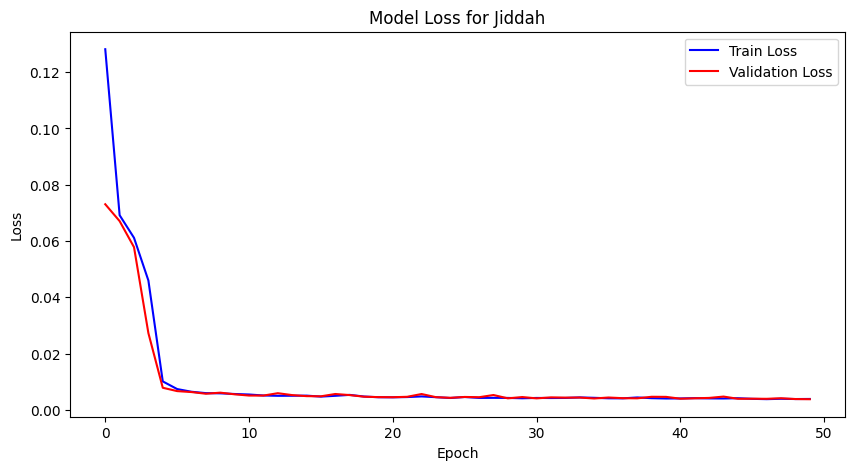

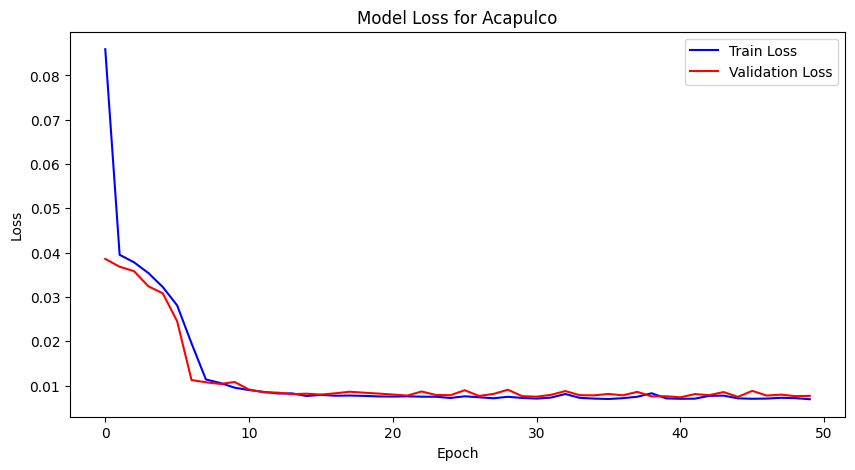

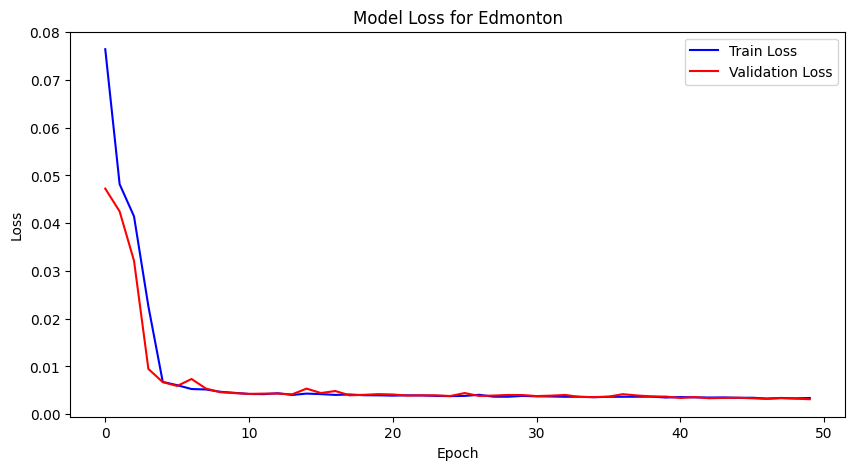

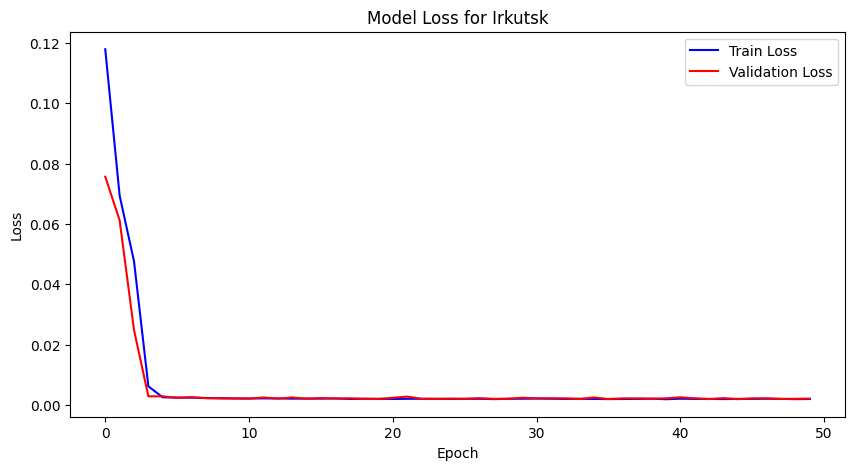

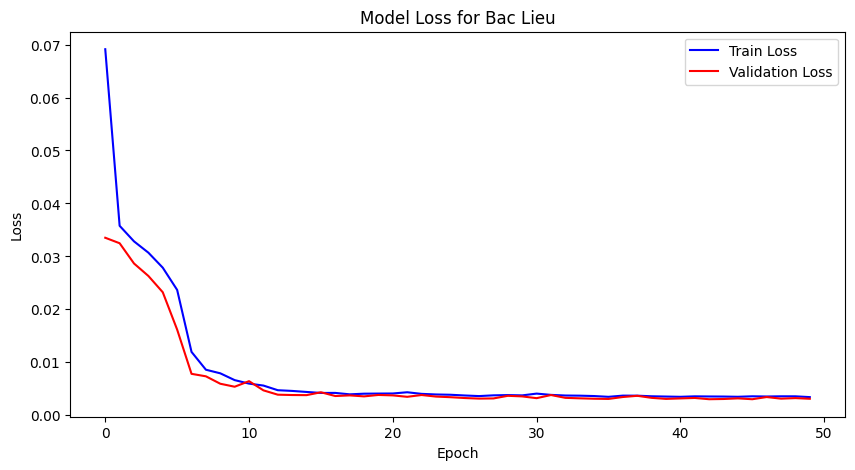

In [10]:

for city, history in histories.items():
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss', color='blue') 
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red') 
    plt.title(f'Model Loss for {city}') 
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


In [ ]:
loaded_models = {}
for city, model_info in models.items():
    _, scaler, test_data, look_back = model_info
    
    model = load_model(f'./Models/Temperature/RandomCities/{city}_model.h5')
    loaded_models[city] = (model, scaler, test_data, look_back)
    print(f"Model for {city} loaded.")

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from math import sqrt

def evaluate_model(city, model_info):
    print(model_info)
    model, scaler, test_data, look_back = model_info 

    testX, testY, _ = preprocess_data(test_data, look_back=look_back, scaler=scaler)

    # Make predictions
    predictions = model.predict(testX)

    # Calculate metrics
    mse = mean_squared_error(testY, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(testY, predictions)
    r2 = r2_score(testY, predictions)
    explained_variance = explained_variance_score(testY, predictions)

    return {
        'City': city,
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae,
        'R-squared': r2,
        'Explained Variance': explained_variance
    }

print(loaded_models)

results = []
for city, model_info in loaded_models.items():
    result = evaluate_model(city, model_info)
    results.append(result)

results_df = pd.DataFrame(results)
print(len(results_df))
results_df


{'Jiddah': (<keras.engine.sequential.Sequential object at 0x7fd941606490>, MinMaxScaler(),                 dt  AverageTemperature  AverageTemperatureUncertainty    City  \
3444959 1979-08-01              32.368                          0.801  Jiddah   
3444960 1979-09-01              32.238                          0.443  Jiddah   
3444961 1979-10-01              30.061                          0.280  Jiddah   
3444962 1979-11-01              28.811                          0.328  Jiddah   
3444963 1979-12-01              24.258                          0.472  Jiddah   
...            ...                 ...                            ...     ...   
3445364 2013-05-01              30.222                          0.541  Jiddah   
3445365 2013-06-01              31.623                          0.740  Jiddah   
3445366 2013-07-01              33.238                          1.001  Jiddah   
3445367 2013-08-01              32.800                          1.425  Jiddah   
3445368 2013-09-01

2024-05-01 22:56:49.955733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:56:49.957847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:56:49.959459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 6s 501ms/step
(<keras.engine.sequential.Sequential object at 0x7fd97011ad90>, MinMaxScaler(),               dt  AverageTemperature  AverageTemperatureUncertainty      City  \
59807 1979-08-01              27.677                          0.456  Acapulco   
59808 1979-09-01              26.597                          0.357  Acapulco   
59809 1979-10-01              27.061                          0.326  Acapulco   
59810 1979-11-01              26.516                          0.625  Acapulco   
59811 1979-12-01              26.628                          0.406  Acapulco   
...          ...                 ...                            ...       ...   
60212 2013-05-01              26.628                          0.929  Acapulco   
60213 2013-06-01              28.092                          0.394  Acapulco   
60214 2013-07-01              27.885                          0.383  Acapulco   
60215 2013-08-01              27.725                   

2024-05-01 22:57:00.728952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:57:00.732563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:57:00.735054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 4s 308ms/step
(<keras.engine.sequential.Sequential object at 0x7fd94176af90>, MinMaxScaler(),                 dt  AverageTemperature  AverageTemperatureUncertainty  \
2168682 1964-09-01               7.933                          0.216   
2168683 1964-10-01               6.476                          0.347   
2168684 1964-11-01              -6.285                          0.368   
2168685 1964-12-01             -20.916                          0.499   
2168686 1965-01-01             -17.476                          0.392   
...            ...                 ...                            ...   
2169266 2013-05-01              12.902                          0.376   
2169267 2013-06-01              14.412                          0.398   
2169268 2013-07-01              15.547                          0.300   
2169269 2013-08-01              16.713                          0.459   
2169270 2013-09-01              13.688                        

2024-05-01 22:57:06.417179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:57:06.419502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:57:06.421136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

15/15 [==============================] - 6s 342ms/step
(<keras.engine.sequential.Sequential object at 0x7fd94069e490>, MinMaxScaler(),                 dt  AverageTemperature  AverageTemperatureUncertainty  \
3227641 1975-02-01             -18.375                          0.432   
3227642 1975-03-01              -7.584                          0.385   
3227643 1975-04-01               0.032                          0.334   
3227644 1975-05-01               7.650                          0.468   
3227645 1975-06-01              12.325                          0.415   
...            ...                 ...                            ...   
3228100 2013-05-01               7.022                          1.003   
3228101 2013-06-01              12.116                          0.437   
3228102 2013-07-01              15.227                          0.498   
3228103 2013-08-01              15.434                          0.699   
3228104 2013-09-01                 NaN                        

2024-05-01 22:57:17.176497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:57:17.178815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:57:17.180734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 4s 321ms/step
(<keras.engine.sequential.Sequential object at 0x7fd978476cd0>, MinMaxScaler(),                dt  AverageTemperature  AverageTemperatureUncertainty  \
514032 1976-01-01              24.038                          0.212   
514033 1976-02-01              24.890                          0.513   
514034 1976-03-01              26.226                          0.519   
514035 1976-04-01              27.462                          0.302   
514036 1976-05-01              27.860                          0.505   
...           ...                 ...                            ...   
514480 2013-05-01              29.404                          0.302   
514481 2013-06-01              29.021                          0.320   
514482 2013-07-01              28.443                          0.588   
514483 2013-08-01              28.385                          0.287   
514484 2013-09-01                 NaN                            NaN   



2024-05-01 22:57:22.776297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:57:22.778458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:57:22.780107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

11/11 [==============================] - 4s 282ms/step
5


,City,RMSE,MSE,MAE,R-squared,Explained Variance
0,Jiddah,0.069194,0.004788,0.053414,0.936156,0.948310
1,Acapulco,0.081488,0.006640,0.063961,0.783652,0.789280
2,Edmonton,0.065736,0.004321,0.048495,0.916248,0.920239
3,Irkutsk,0.046104,0.002126,0.034776,0.968398,0.968808
4,Bac Lieu,0.056832,0.003230,0.045396,0.871378,0.884933


In [13]:
def predict_future(model, scaler, test_data, look_back, months=30):

    print("Initial test data shape:", test_data.shape)
    print(test_data.head())

    # Interpolate and resample
    test_data[['AverageTemperature', 'AverageTemperatureUncertainty']] = test_data[['AverageTemperature', 'AverageTemperatureUncertainty']].interpolate()

    test_data = test_data[['dt', 'AverageTemperature', 'AverageTemperatureUncertainty']]
    test_data = test_data.set_index('dt').resample('MS').mean()

    # Ensure the shape for input sequence matches
    last_points = test_data.values[-look_back:]
    input_seq = scaler.transform(last_points) 
    input_seq = input_seq.reshape((1, look_back, 2))

    # Predict forecasts
    predictions = []
    for _ in range(months):
        pred = model.predict(input_seq)
        predictions.append(pred[0, 0])

        # Create a row for prediction with all features
        new_row = np.array([pred[0, 0], 0])
        new_row = scaler.transform([new_row]).reshape(1, 1, 2)
        input_seq = np.append(input_seq[:, 1:, :], new_row, axis=1)

    # Inverse transform predictions to original scale
    predictions = np.array(predictions).reshape(-1, 1)
    mock_uncertainty = np.zeros_like(predictions)
    predictions_with_mock = np.hstack((predictions, mock_uncertainty))
    predictions_inversed = scaler.inverse_transform(predictions_with_mock)[:, 0]

    return predictions_inversed


cities = ['Jiddah', 'Acapulco', 'Edmonton', 'Irkutsk', 'Bac Lieu']
forecasts = {}

for city in cities:
    model, scaler, test_data, look_back = models[city]
    forecasts[city] = predict_future(model, scaler, test_data, look_back, months=120)

Initial test data shape: (410, 7)
                dt  AverageTemperature  AverageTemperatureUncertainty    City  \
3444959 1979-08-01              32.368                          0.801  Jiddah   
3444960 1979-09-01              32.238                          0.443  Jiddah   
3444961 1979-10-01              30.061                          0.280  Jiddah   
3444962 1979-11-01              28.811                          0.328  Jiddah   
3444963 1979-12-01              24.258                          0.472  Jiddah   

              Country Latitude Longitude  
3444959  Saudi Arabia   21.70N    38.94E  
3444960  Saudi Arabia   21.70N    38.94E  
3444961  Saudi Arabia   21.70N    38.94E  
3444962  Saudi Arabia   21.70N    38.94E  
3444963  Saudi Arabia   21.70N    38.94E  
1/1 [==============================] - 1s 543ms/step


2024-05-01 22:57:28.474098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:57:28.476455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:57:28.478218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 73ms/step
Initial test data shape: (410, 7)
              dt  AverageTemperature  AverageTemperatureUncertainty      City  \
59807 1979-08-01              27.677                          0.456  Acapulco   
59808 1979-09-01              26.597                          0.357  Acapulco   
59809 1979-10-01              27.061                          0.326  Acapulco   
59810 1979-11-01              26.516                          0.625  Acapulco   
59811 1979-12-01              26.628                          0.406  Acapulco   

      Country Latitude Longitude  
59807  Mexico   16.87N   100.47W  
59808  Mexico   16.87N   100.47W  
59809  Mexico   16.87N   100.47W  
59810  Mexico   16.87N   100.47W  
59811  Mexico   16.87N   100.47W  
1/1 [==============================] - 1s 513ms/step


2024-05-01 22:57:44.487858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:57:44.490162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:57:44.491983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 30ms/step
Initial test data shape: (589, 7)
                dt  AverageTemperature  AverageTemperatureUncertainty  \
2168682 1964-09-01               7.933                          0.216   
2168683 1964-10-01               6.476                          0.347   
2168684 1964-11-01              -6.285                          0.368   
2168685 1964-12-01             -20.916                          0.499   
2168686 1965-01-01             -17.476                          0.392   

             City Country Latitude Longitude  
2168682  Edmonton  Canada   53.84N   113.18W  
2168683  Edmonton  Canada   53.84N   113.18W  
2168684  Edmonton  Canada   53.84N   113.18W  
2168685  Edmonton  Canada   53.84N   113.18W  
2168686  Edmonton  Canada   53.84N   113.18W  
1/1 [==============================] - 0s 460ms/step


2024-05-01 22:57:56.185414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:57:56.187546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:57:56.189176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 31ms/step
Initial test data shape: (464, 7)
                dt  AverageTemperature  AverageTemperatureUncertainty  \
3227641 1975-02-01             -18.375                          0.432   
3227642 1975-03-01              -7.584                          0.385   
3227643 1975-04-01               0.032                          0.334   
3227644 1975-05-01               7.650                          0.468   
3227645 1975-06-01              12.325                          0.415   

            City Country Latitude Longitude  
3227641  Irkutsk  Russia   52.24N   105.11E  
3227642  Irkutsk  Russia   52.24N   105.11E  
3227643  Irkutsk  Russia   52.24N   105.11E  
3227644  Irkutsk  Russia   52.24N   105.11E  
3227645  Irkutsk  Russia   52.24N   105.11E  


2024-05-01 22:58:07.749393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:58:07.751816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:58:07.753506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 37ms/step
Initial test data shape: (453, 7)
               dt  AverageTemperature  AverageTemperatureUncertainty  \
514032 1976-01-01              24.038                          0.212   
514033 1976-02-01              24.890                          0.513   
514034 1976-03-01              26.226                          0.519   
514035 1976-04-01              27.462                          0.302   
514036 1976-05-01              27.860                          0.505   

            City  Country Latitude Longitude  
514032  Bac Lieu  Vietnam    8.84N   106.22E  
514033  Bac Lieu  Vietnam    8.84N   106.22E  
514034  Bac Lieu  Vietnam    8.84N   106.22E  
514035  Bac Lieu  Vietnam    8.84N   106.22E  
514036  Bac Lieu  Vietnam    8.84N   106.22E  
1/1 [==============================] - 1s 544ms/step


2024-05-01 22:58:24.895321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-01 22:58:24.897721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-01 22:58:24.899471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 50ms/step


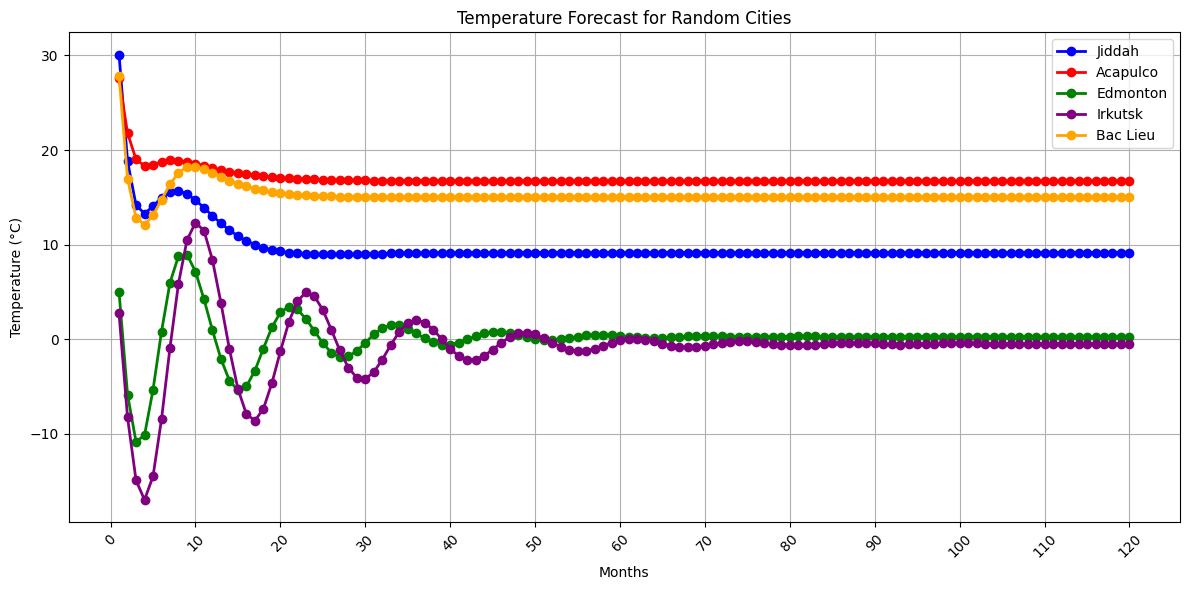

In [14]:
months_120 = range(1, 121)
plt.figure(figsize=(12, 6))
colors = ['blue', 'red', 'green', 'purple', 'orange']
for i, city in enumerate(cities):
    plt.plot(months_120, forecasts[city], marker='o', linestyle='-', color=colors[i], linewidth=2, label=f'{city}')

plt.title('Temperature Forecast for Random Cities')
plt.xlabel('Months')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(range(0, 121, 10), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

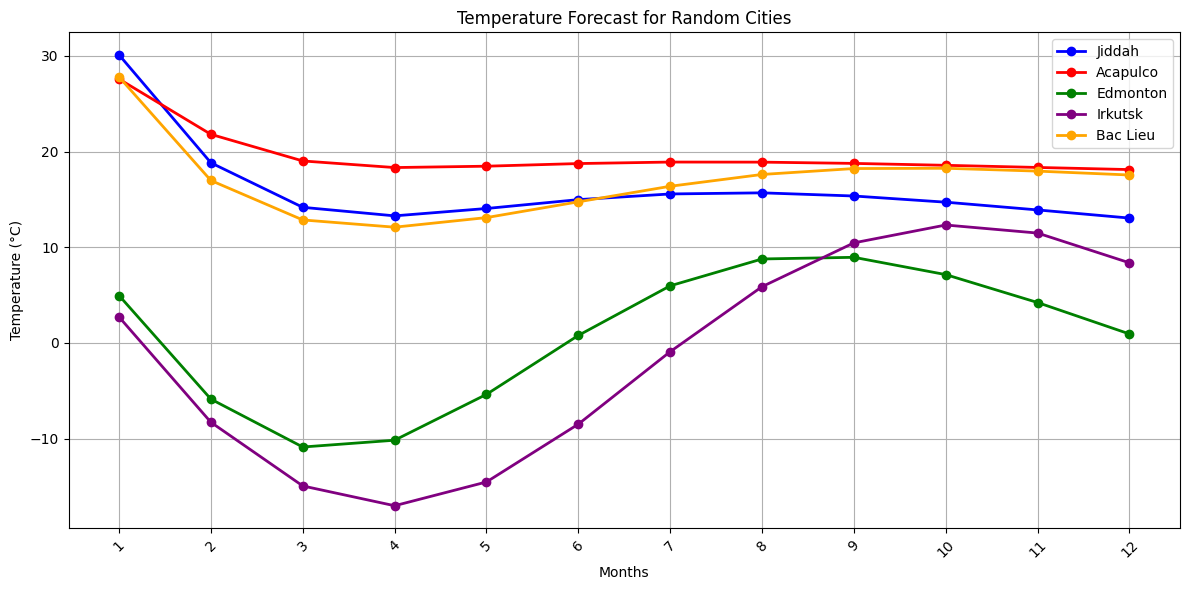

In [15]:
cities = ['Jiddah', 'Acapulco', 'Edmonton', 'Irkutsk', 'Bac Lieu']
colors = ['blue', 'red', 'green', 'purple', 'orange']
months_12 = range(1, 13)

plt.figure(figsize=(12, 6))
for i, city in enumerate(cities):
    plt.plot(months_12, forecasts[city][:12], marker='o', linestyle='-', color=colors[i], linewidth=2, label=f'{city}')

plt.title('Temperature Forecast for Random Cities')
plt.xlabel('Months')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(months_12, rotation=45) 
plt.legend()
plt.tight_layout()
